<a href="https://colab.research.google.com/github/boyoung21/ESAA/blob/main/0912_%ED%95%B8%EC%A6%88%EC%98%A8_%EC%95%99%EC%83%81%EB%B8%94%EA%B3%BC_rf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# chap 7 앙상블 학습과 랜덤 포레스트

일련의 예측기(분류나 회귀 모델)로부터 예측을 수집하면 더 좋은 예측을 얻을 수 있음. 이러한 일련의 예측기를 앙상블이라 하며, 해당 앙상블로 훈련하는 것을 앙상블 학습이라고 함. 앙상블 학습 알고리즘은 앙상블 방법.

주로 프로젝트 마지막에서 앙상블 방법을 사용하여 더 좋은 예측기를 만들기도 함.

훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정트리 분류기를 훈련시킬 수 있음. 모든 개별 트리의 예측을 구한 다음, 가장 많은 선택을 받은 클래스를 예측으로 삼음. 결정 트리의 앙상블을 랜덤 포레스트라고 함.



# 7.1 투표 기반 분류기

더 좋은 분류기를 만드는 매우 간단한 방법은, 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것. 이렇게 다수결 투표로 정해지는 분류기를 hard voting(직접 투표) 분류기라고 함.

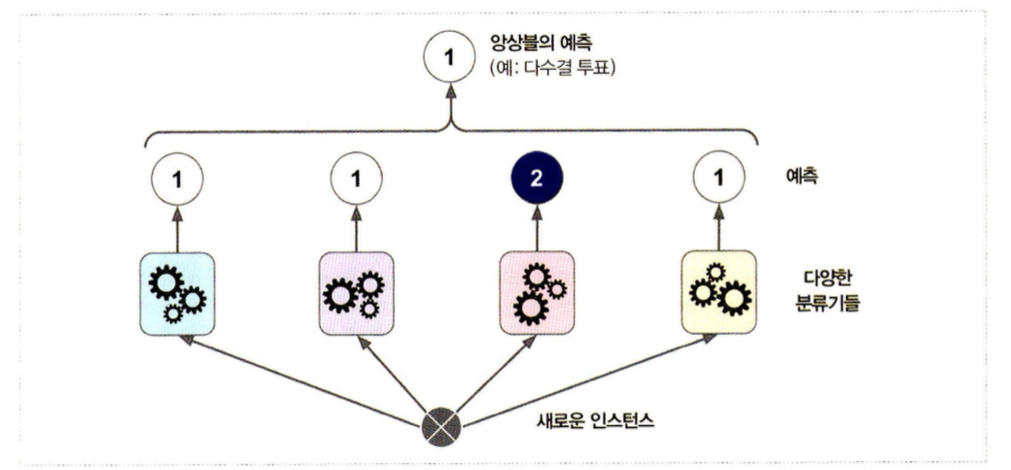

각 분류기가 약한 학습기(weak learner, 랜덤 추측보다 조금 더 높은 성능을 내는 분류기)더라도 충분하게 많고 다양하다면 앙상블은 높은 정확도를 내는 강한 학습기(strong learner)가 될 수 있음.

-> 다만 예측기가 가능한 서로 독립적일 때, 오차에 상관관계가 없을 때 최고의 성능을 발휘함. 다양한 분류기를 얻는 방법 중 하나로는 각기 다른 알고리즘으로 학습시키는 것이 있는데, 매우 다른 종류의 오차를 만들 가능성이 높아 앙상블 모델의 정확도를 향상시킬 수 있기 때문

In [13]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

# 5장에서의 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X, y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
# 투표 기반 분류기를 만들고 훈련시키는 코드

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [15]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
RandomForestClassifier 0.95
SVC 0.95
VotingClassifier 0.95


투표 기반 분류기가 다른 개별 분류기보다 성능이 더 높게 나옴

모든 분류기가 클래스의 확률을 예측할 수 있으면(predict_proba() 메서드가 있으면) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측 가능 -> **간접 투표(soft voting)**

소프트 보팅은 확률이 높은 투표에 비중을 더 두기 때문에 하드 보팅보다 성능이 더 높음. (voting = "soft" 로 설정하고 모든 분류기가 클래스의 확률을 추정할 수 있으면 됨.)

SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야 함. -> 클래스 확률을 추정하기 위해 교차 검증을 사용하므로 훈련 속도가 느려지지만 predict_proba() 메서드를 사용할 수 있음.


# 7.2 배깅과 페이스팅

다양한 분류기를 만드는 또 다른 방법으로, 같은 알고리즘을 사용하되 훈련 세트의 서브셋을 무작위로 구성하여 분류기를 각기 다르게 학습시키는 것.

배깅(bagging, bootstrap aggregating): 훈련 세트에서 중복을 허용하여 샘플링하는 방식
페이스팅(pasting): 중복을 허용하지 않고 샘플링하는 방식

즉, 중복 허용에서만 차이를 보일 뿐 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있음.

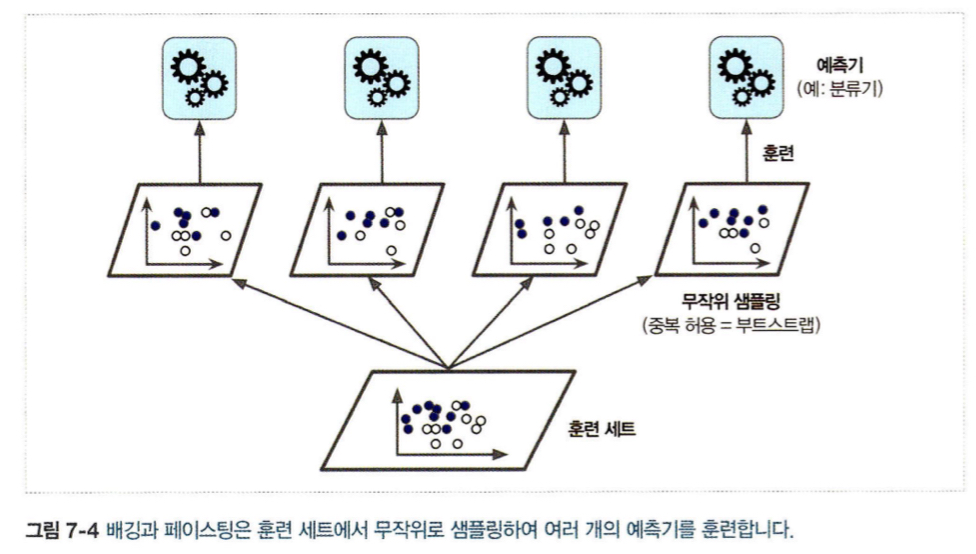

voting은 동일한 전체 데이터를 각기 다른 분류기에 사용하는 거고, 배깅은 같은 알고리즘을 랜덤 샘플링한 데이터로 학습시킨다는 데에서 차이가 존재함.

보팅은 모델 다양성에 의존하고, 배깅은 데이터 다양성에 의존하는 방식

분류일 때는 통계적 최빈값을, 회귀일 때는 평균을 계산하여 새로운 샘플에 대한 예측을 만듦. 이때 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수, 즉, 앙상블 예측을 거치면 편향과 분산이 모두 감소하여 정확도가 높아짐. 앙상블의 결과는 원본 데이터세트로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦.

# 7.2.1 사이킷런의 배경과 페이스팅

배깅과 페이스팅을 위해 사이킷런에서는 BaggingClassifier 제공.

bagging이 기본이며, 페이스팅을 사용하고 싶을 경우 boostrap = False 지정하면 돰

n_jobs: 훈련과 예측에 사용할 CPU 코어 수를 지정, -1로 지정할 경우 가용한 모든 코어 사용

BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면 직접 투표 대신 자동으로 간접 투표 방식을 사용

직접 투표는 각 모델의 확률 값은 무시하고 결과만 사용하여 다수결로 정하는 방식

간접 투표는 클래스별 확률을 내고 평균이나 가중합으로 최종 클래스 결정. 그래서 간접 투표 방식이 보통 성능이 더 안정적이며 신뢰도 높음.

In [16]:
# 결정 트리 분류기 500개의 앙상블 훈련 코드

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

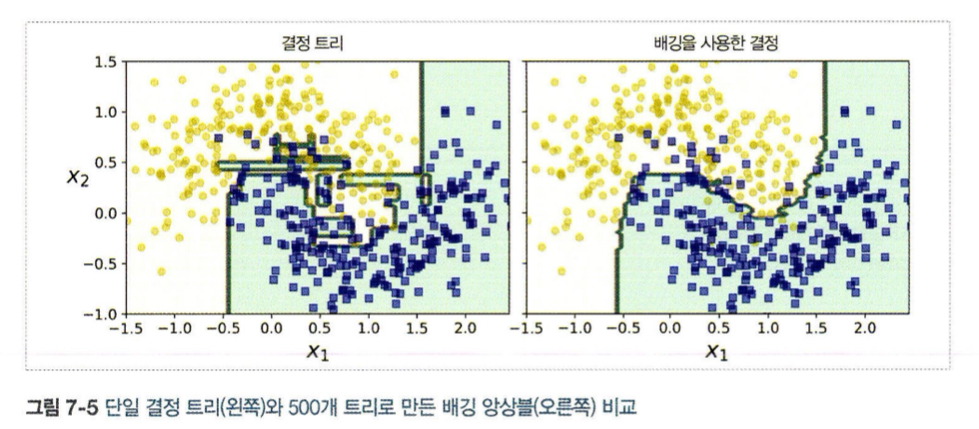

위 그래프는 단일 결정 트리의 결정 경계와 500개의 트리를 사용한 배깅 앙상블의 결정 경계를 비교한 것. 앙상블의 예측이 단일 결정 트리보다 일반화가 훨씬 더 잘된 것을 볼 수 있음. 앙상블이 비슷한 편향에서 더 작은 분산을 만들기 때문임. (훈련 세트의 오차 수가 거의 비슷하지만 결정 경계는 덜 불규칙함)

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로(중복 허용이라) 배깅이 페이스팅보다 편향이 조금 더 높음. 대신 다양성으로 인해 예측기들의 상관관계가 감소하므로 앙상블의 분산은 감소함.

# 7.2.2 oob 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 사용되지 않음. BaggingClassifier는 기본값으로 중복을 허용하는데, 이때 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링됨. 선택되지 않은 훈련 샘플의 나머지 37%를 oob(out if bag) 샘플이라고 함. 예측기마다 남겨진 37%는 모두 다름

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 별도의 검증 세트를 만들거나 사용할 필요 없이 oob 샘플을 사용해 모델 성능을 평가할 수 있음. 앙상블의 평가는 각 예측기의 oob 평가를 평가하여 얻음.

사이킷런에서 BaggingClassifier를 만들 때 oob_score = True로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행함. -> 평가 점수 결과는 oob_score_ 변수에 저장되어 있음

In [17]:
# 테스트 세트에 적용하기 전 oob 샘플로 정확도 평가

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators = 500,
    bootstrap = True, n_jobs = -1, oob_score = True)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9125

In [18]:
# 테스트 세트로 정확도 평가

from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.95

oob 샘플에 대한 결정 함수의 값은 oob_decision_function_ 변수에서 확인 가능. 이 경우 결정 함수는 각 훈련 샘플의 클래스 확률을 반환함.

In [19]:
# 결과 왼쪽이 훈련 샘플이 음성 클래스에 속할 확률, 오른쪽은 양성

bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.97237569, 0.02762431],
       [0.43718593, 0.56281407],
       [1.        , 0.        ],
       [0.00518135, 0.99481865],
       [1.        , 0.        ],
       [0.35164835, 0.64835165],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.40909091, 0.59090909],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.96470588, 0.03529412],
       [0.        , 1.        ],
       [0.04046243, 0.95953757],
       [0.        , 1.        ],
       [0.74193548, 0.25806452],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.96216216, 0.03783784],
       [0.

# 7.3 랜덤 패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링을 지원함.

샘플링 조절 매개변수
- max_features -> 작동 방식은 max_samples와 동일
- bootstrap_features -> 작동 방식은 bootstrap과 동일

그러나 차이점은 샘플이 아닌 **특성에 대한 샘플링**

각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련됨
-> 매우 고차원의 데이터세트를 다룰 때 유용함

훈련 특성과 샘플을 모두 샘플링하는 것: 랜덤 패치 방식(random patches method), bootstrap_features = False & max_samples = 1.0
훈련 샘플은 모두 사용하고 특성은 샘플링 하는 것: 랜덤 서브스페이스 방식(random subspaces method), 위와 반대

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리지만 분산을 낮추는 효과가 있음.

# 7.4 랜덤 포레스트

랜덤 포레스트는 일반적으로 배깅 또는 페이스팅을 적용한 결정 트리의 앙상블

max_samples -> 전형적으로 훈련 세트의 크기로 지정

위에서는 BaggingClassifier에 DecesionTreeClassifier를 넣었는데, RandomForestClassifier를 사용할 수도 있음.

BaggingClassifier는 결정 트리 이외의 모델을 앙상블하고 싶을 때 유용

In [20]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입함. (무작위로 특성을 먼저 선택하 -> 그 무작위 내에서 최적의 조합을 찾는 식)
> 트리를 더욱 다양하게 만들어 편향을 높이는 대신 분산을 낮춤

In [21]:
# BaggingClassifier를 사용해 앞의 rf 코드와 비슷하게 만든 것

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter = 'random', max_leaf_nodes = 16),
    n_estimators = 500, max_samples = 1.0, bootstrap = True, n_jobs = -1)

# 7.4.1 엑스트라 트리

랜덤 포레스트는 트리를 만들 때 각 노드가 무작위로 특성의 서브셋을 만들어 분할에 사용함. 최적의 임곗값을 찾는 보통의 결정 트리와 달리 트리를 더욱 무작위하게 만들기 위해 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택함.

**익스트림 랜덤 트리(extremely randomized trees, 또는 엑스트라 트리 extra-trees)**: 극단적으로 무작위한 트리의 랜덤 포레스트 -> 편향이 증가하는 대신 분산이 낮아짐. 그리고 소요 시간도 훨씬 빠름. 사이킷런의 ExtraTreeClassifier / ExtraTreeRegressor

# 7.4.2 특성 중요도

랜덤 포레스트는 특성의 상대적 중요도를 측정하기 쉽다는 장점이 존재함. (feature_importances_) 사이킷런은 어떤 특성을 사용한 노드가 랜덤 포레스트에 있는 모든 트리에 걸쳐서 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정함. 이는 가중치 평균이며, 각 노드의 가중치는 연관된 훈련 샘플수와 같음.

In [23]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators = 500, n_jobs = -1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.09160136177344322
sepal width (cm) 0.023099047934022555
petal length (cm) 0.4301763159102245
petal width (cm) 0.4551232743823098


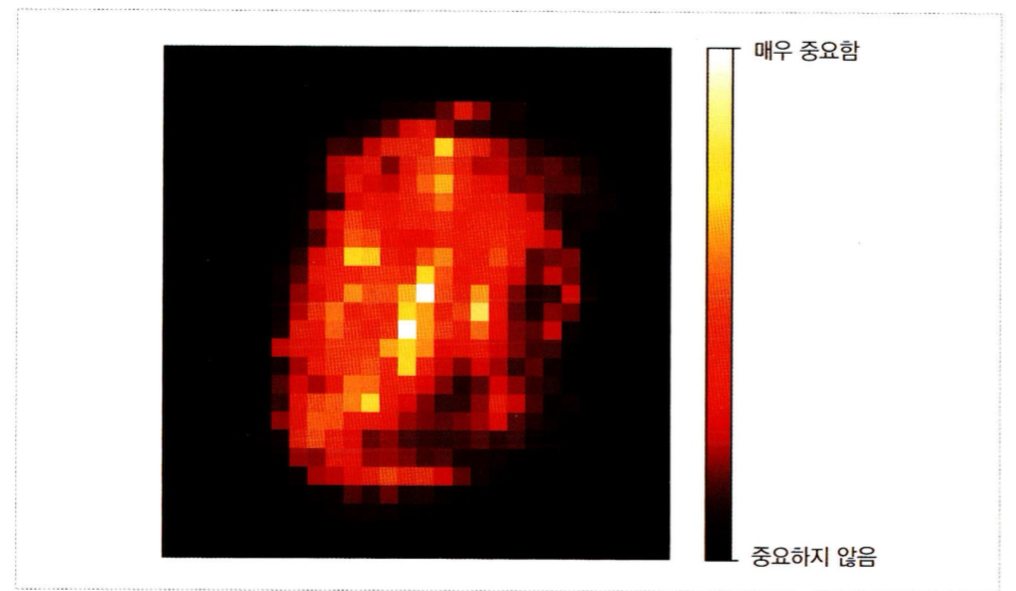

위의 그래프는 MNIST 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 각 픽셀의 중요도를 그래프로 나타낸 것. 이렇듯 랜덤 포레스트는 특성을 선택해야 할 때 어떤 특성이 중요한지 빠르게 확인 가능하다는 장점이 있음.